Project Summary: <br>
1.	Build a model to classify pieces of images as vehicles /non vehicles. For that I have needed: 
    - Perform feature extraction with HOG (Histogram of oriented gradient), color and space features
    - Train a linear model with SVM using the data set provided to classify vehicles and non-vehicles images 
2.	Implement a sliding window technique to search for vehicles in test images
    - Multi scale windows
    - Handling multiple detection and false positives
3.	Write a pipeline that draw detected cars, using all the techniques developed before, in video images. Apply that in the project video.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

import glob
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## PART 1: Build a model to classify pieces of images as vehicles /non vehicles 

###  1.1 DATA Loading and Exploratory

In [ ]:
It captures robust variations in shape
Parameters to tweak: 
    # of orientation bins
    - grid of cells
    - cell sizes
    - adding overlap between cells
    - block normalization

In [4]:
# DATA EXPLORATION
cars = glob.glob('vehicles/**/*.png')
notcars = glob.glob('non-vehicles/**/*.png')
print(len(cars), len(notcars))

8792 8968


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


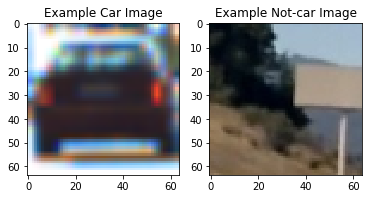

In [5]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

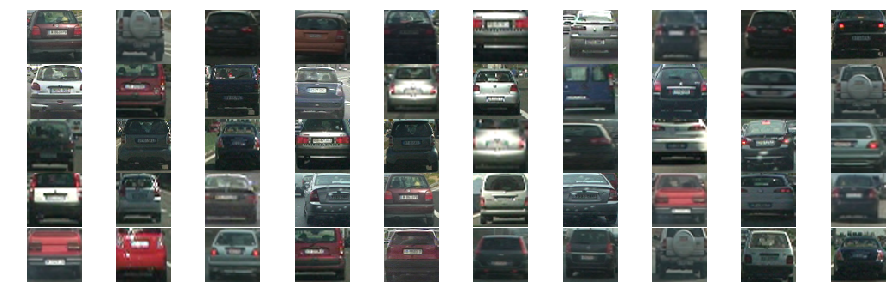

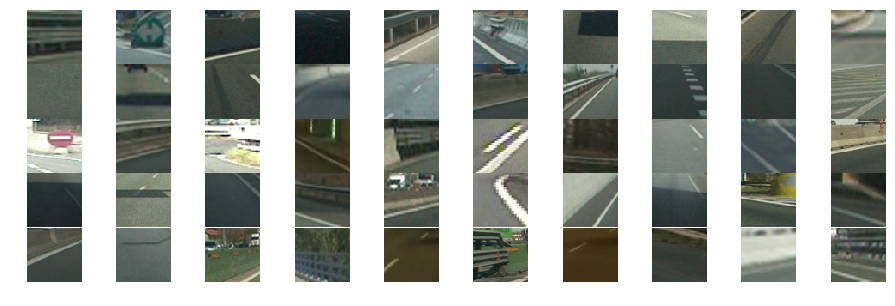

In [51]:
fig, axes = plt.subplots(5, 10, figsize=(16,5))
fig.subplots_adjust(hspace = .004, wspace=.002)
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(mpimg.imread(cars[i]))
    #ax.set_title('car')
plt.show()

fig, axes = plt.subplots(5, 10, figsize=(16,5))
fig.subplots_adjust(hspace = .004, wspace=.002)
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(mpimg.imread(notcars[i]))
    #ax.set_title('Noncar')
plt.show()

### 1.2 HOG features extraction

In [6]:
# Define a function to return HOG features and visualization
#------------------------------------------------------------
def get_hog_features(img, orient, pix_per_cell, cell_per_block,  vis=False, feature_vec=True):

    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False,  visualise=vis, feature_vector=feature_vec)
        return(features, hog_image)
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False,  visualise=vis, feature_vector=feature_vec)
        return(features)

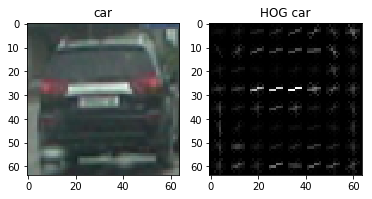

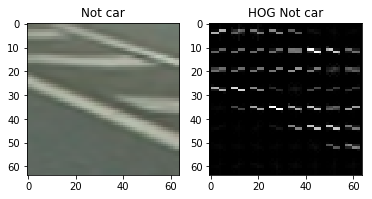

In [78]:
# Visualize some example:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
car_img = mpimg.imread(cars[150])
#gray = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
#print(car_img.shape[2])

ax1.imshow(car_img)
ax1.set_title('car')
features, hog_image = get_hog_features(car_img[:,:,0], 9, 8, 8, vis=True, feature_vec=True)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG car')
    
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
notcars_img = mpimg.imread(notcars[150])

ax1.imshow(notcars_img)
ax1.set_title('Not car')
features, hog_image = get_hog_features(notcars_img[:,:,0], 9, 8, 8, vis=True, feature_vec=True)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Not car')
    
plt.show()

### 1.3 Color and spatial features extraction

In [7]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


We implement here functions to extract features: <br>
If we just want HOG features, we will use extract_features_hog
If we want a combination of HOG, colors and spatial features, that would help to get better prediction results, we use extract_features

In [8]:
#########################################################################
# Define a function to extract HOG features from a list of images
#########################################################################
def extract_features_hog(imgs, color_space='RGB',orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
     
        
        # Call get_hog_features() with vis=False, feature_vec=True

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return (features)
################################################################################################
# Define a global function that extracts HOG, colors and spatial features from a list of images
################################################################################################

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return(features)


In [9]:
# Feature extraction parameters
colorspace = 'YUV'#  RGB, HSV, LUV, HLS, YUV, YCrCb, 'YUV' 
orient =    11 # 9 #
pix_per_cell = 16 # 8 # 
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2
#------------------
spatial_size=(16, 16)
hist_bins=16


t=time.time()
            
car_features = extract_features(cars, color_space=colorspace, spatial_size = spatial_size, hist_bins = hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, spatial_size = spatial_size, hist_bins = hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract  features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

#-------------------------------------------------------
# Fit a per-column scaler, just needed if combining different types of features : HOG, colors, and spatial
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
#-------------------------------------------------------

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print(len(X), len(y))


93.21 Seconds to extract  features...
17760 17760


In [71]:
X.shape

(17760, 6108)

### 1.4 Splitting and training a linear model with SVM 

In [12]:
# Split up data into randomized training and test sets
#-----------------------------------------------------
rand_state = np.random.randint(0, 100)
#--- if we have just HOG features, we don't scale, and can use directly X
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
#---- if we have 3 kind of features, we have to use scaled data: scaled_X
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('X_train sample size:', len(X_train))
print('X_test sample size:', len(X_test))

# Use a linear SVC 
#-----------------------------------------------------
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2004
X_train sample size: 14208
X_test sample size: 3552
5.09 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:  [ 0.  1.  1.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  1.  1.  1.  0.]
0.01252 Seconds to predict 10 labels with SVC


## PART 2: Implement a sliding window technique to search for vehicles in test images

The method chosen for doing the sliding window approach, is one that allows us to only have to extract the Hog features once.
The code below defines a single function find_cars that's able to both extract features and make predictions. (code extracted from lesson material, section 35) <br>
The find_cars only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [29]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# The function returns a list of boxes where a car is detected
#-----------------------------------------------------------------------------------------------
def find_cars(img, ystart, ystop, scale, color_space, hog_channel, 
              svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, test= False):
    #print(hog_channel, color_space)
    boxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # Color conversion if not 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]
        
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)  + 1 #- cell_per_block
    nyblocks = (ch1.shape[0] // pix_per_cell)  + 1 #- cell_per_block
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1 #- cell_per_block + 1
    #print('nblocks_per_window: ', nblocks_per_window)
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image. 
    # To do this, apply skimage.feature.hog() with the flag feature_vec=False, 

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False,feature_vec=False)   

    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False,feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False,feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch

            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # For Colors and spatial features---------------------------
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            # ---------------------------------------------------------
            
            # calculing prediction n case No colors or spatial fetures:
            #test_prediction = svc.predict(hog_features)
            
            #print(test_prediction)
            if test_prediction == 1 or test == True: #In case test is True, we want to plot all possible sliding windows
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return (boxes)
    #return (draw_img)
    
#ystart = 400
#ystop = 656
#scale = 1.5
#color_space = colorspace
#hog_channel = 'ALL'

#out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

#plt.imshow(out_img)

### 2.1 Testing with different scales

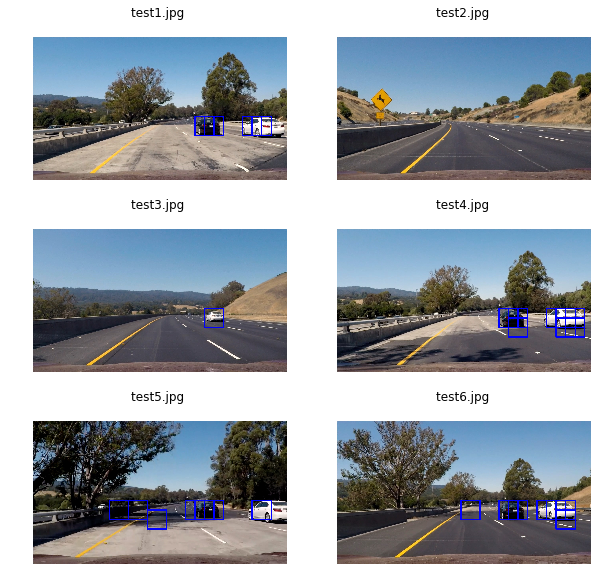

In [14]:
ystart = 400
ystop = 656
scale = 1.5

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


#window_img = draw_boxes(test_img, boxes)                    
#plt.imshow(window_img)
fig, axes = plt.subplots(3, 2, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ind = i+1
    test_img = mpimg.imread('./test_images/test{ind}.jpg'.format(ind = ind))
    # get detected boxes for the image:

    boxes = find_cars(test_img, ystart , ystop , scale, colorspace , 
                      hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #print(len(boxes), 'Boxes found in image')
    
    window_img = draw_boxes(test_img, boxes)         
    ax.set_title('test{ind}.jpg \n'.format(ind = ind))
    ax.imshow(window_img)
    
plt.show()
#fig.savefig('output_images/test_images_withboxes_withcolornadspace.png')

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 496), (96, 592)), ((0, 544), (96, 640)), ((48, 400), (144, 496)), ((48, 448), (144, 544)), ((48, 496), (144, 592)), ((48, 544), (144, 640)), ((96, 400), (192, 496)), ((96, 448), (192, 544)), ((96, 496), (192, 592)), ((96, 544), (192, 640)), ((144, 400), (240, 496)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((144, 544), (240, 640)), ((192, 400), (288, 496)), ((192, 448), (288, 544)), ((192, 496), (288, 592)), ((192, 544), (288, 640)), ((240, 400), (336, 496)), ((240, 448), (336, 544)), ((240, 496), (336, 592)), ((240, 544), (336, 640)), ((288, 400), (384, 496)), ((288, 448), (384, 544)), ((288, 496), (384, 592)), ((288, 544), (384, 640)), ((336, 400), (432, 496)), ((336, 448), (432, 544)), ((336, 496), (432, 592)), ((336, 544), (432, 640)), ((384, 400), (480, 496)), ((384, 448), (480, 544)), ((384, 496), (480, 592)), ((384, 544), (480, 640)), ((432, 400), (528, 496)), ((432, 448), (528, 544)), ((432, 496), (528, 592)), ((432

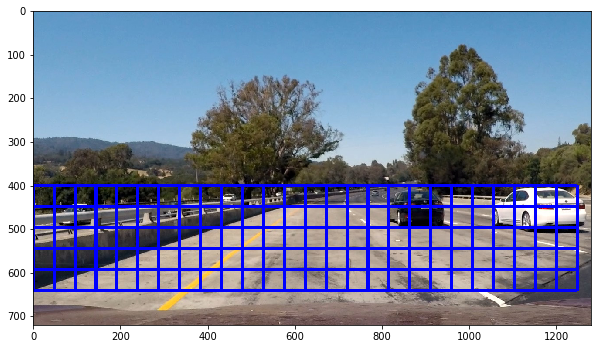

In [30]:
ystart = 400
ystop = 656
scale = 1.5

test_img = mpimg.imread('./test_images/test1.jpg')
    # get detected boxes for the image:
boxes = find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins, test =True)
print(boxes)
test_img_rects = draw_boxes(test_img, boxes)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
#fig.savefig('output_images/test1_withboxes_withcolornadspace.png')

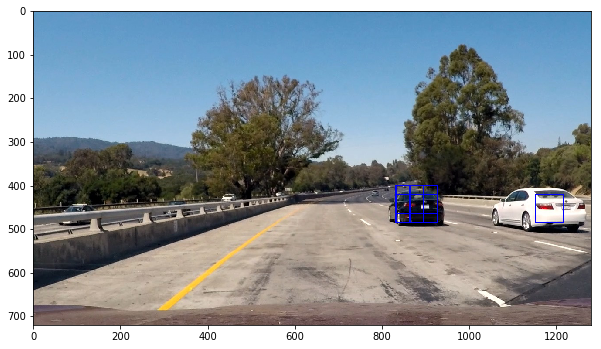

In [43]:
# Small boxis in the horizon
test_img = mpimg.imread('./test_images/test1.jpg')

multi_boxes = []
ystart = 400
ystop = 464# 600 #ystop = 464
scale = 1.0
multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins, test = False))



ystart = 420
ystop = 484 #620 #ystop = 480
scale = 1.0
multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins, test = False))


boxes = [item for elem in multi_boxes for item in elem] 

test_img_rects = draw_boxes(test_img, boxes,  thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
#fig.savefig('output_images/test1_withboxes_withcolornadspace_small_min.png')

Num. boxes:  50


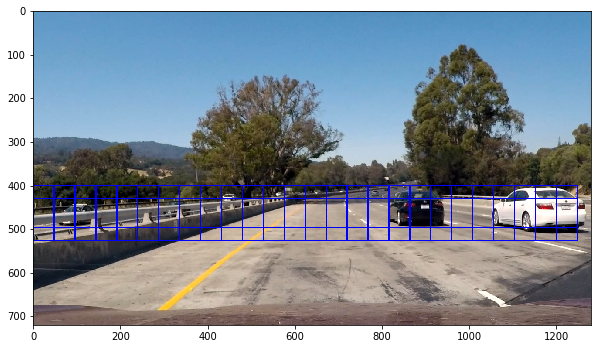

In [41]:
## Medium boxes at 1.5 
test_img = mpimg.imread('./test_images/test1.jpg')

multi_boxes = []

ystart = 400
ystop = 496
scale = 1.5
multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins, test = True))
    
ystart = 430
ystop = 526
scale = 1.5
multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins, test = True))

boxes = [item for elem in multi_boxes for item in elem] 

test_img_rects = draw_boxes(test_img, boxes,  thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Num. boxes: ', len(boxes))
#fig.savefig('output_images/test1_withboxes_withcolornadspace_medium_15.png')

Num. boxes:  3


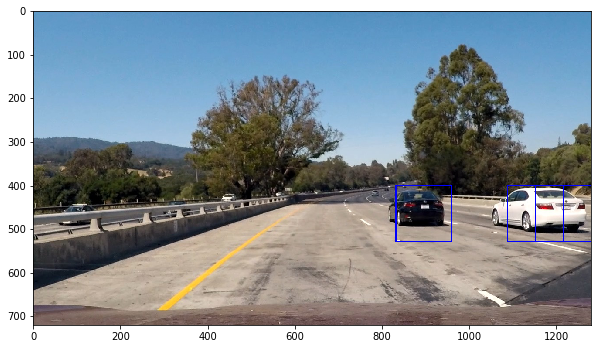

In [42]:
## Medium boxes at 2.0
test_img = mpimg.imread('./test_images/test1.jpg')

multi_boxes = []

ystart = 400
ystop = 528
scale = 2.0
multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins, test = False))
ystart = 432
ystop = 560
scale = 2.0
multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins, test = False))

boxes = [item for elem in multi_boxes for item in elem] 

test_img_rects = draw_boxes(test_img, boxes,  thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Num. boxes: ', len(boxes))
#fig.savefig('output_images/test1_withboxes_withcolornadspace_medium.png')

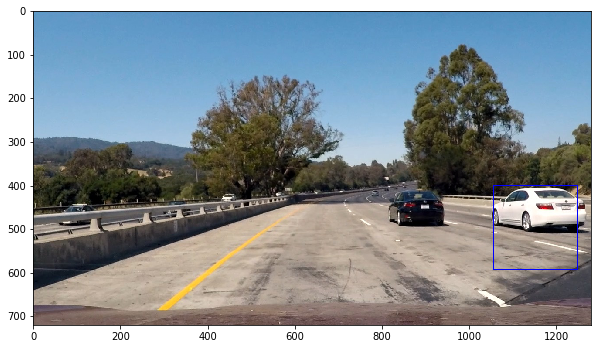

In [46]:
## Bigger boxes:
test_img = mpimg.imread('./test_images/test1.jpg')

multi_boxes = []

ystart = 400
ystop = 592
scale = 3.0
multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins, test = False))
ystart = 460
ystop = 652
scale = 3.0
multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins, test = False))

boxes = [item for elem in multi_boxes for item in elem] 

test_img_rects = draw_boxes(test_img, boxes,  thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
#fig.savefig('output_images/test1_withboxes_withcolornadspace_large.png')

Num. boxes:  15


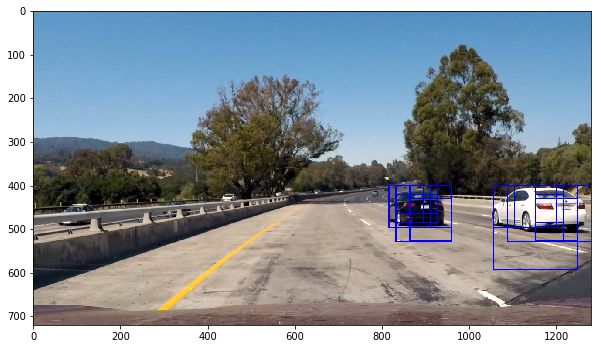

In [48]:
## Putting all multi boxes together...
##----------------------------------
def get_multi_boxes(test_img,colorspace,orient,pix_per_cell, cell_per_block,hog_channel):

    multi_boxes = []
        

    # 2 rows of Small WINDOWS (64x64)--------------------------
    ystart = 400
    ystop = 464
    scale = 1.0
    multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 420
    ystop = 484
    scale = 1.0
    multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    # 2 rows of Medium windows at 1.5-------------------------
    ystart = 400
    ystop = 496
    scale = 1.5
    multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 430
    ystop = 526
    scale = 1.5
    multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
 
    # 2 rows of Medium windows at 2.0-------------------------
    ystart = 400
    ystop = 528
    scale = 2.0
    multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 432
    ystop = 560
    scale = 2.0
    multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins))


    # 2 rows of Big boxes at 3.0-------------------------
    ystart = 400
    ystop = 592
    scale = 3.0
    multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 460
    ystop = 652
    scale = 3.0
    multi_boxes.append(find_cars(test_img, ystart , ystop , scale, colorspace , 
                hog_channel , svc , X_scaler, orient , pix_per_cell, cell_per_block, spatial_size, hist_bins))

    boxes = [item for elem in multi_boxes for item in elem] 
    return(boxes)

test_img = mpimg.imread('./test_images/test1.jpg')
boxes = get_multi_boxes(test_img,colorspace,orient,pix_per_cell, cell_per_block,hog_channel)
test_img_rects = draw_boxes(test_img, boxes,  thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Num. boxes: ', len(boxes))
fig.savefig('output_images/test1_withboxes_withcolornadspace_mix.png')

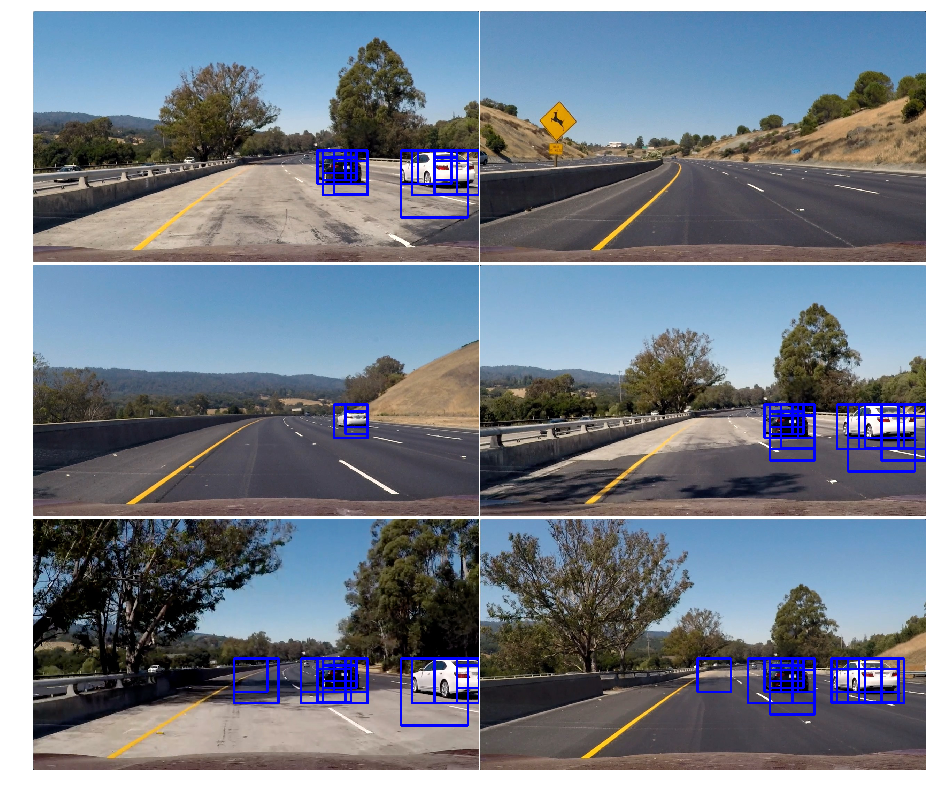

In [52]:
## Test images with multi boxes:
fig, axes = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ind = i+1
    test_img = mpimg.imread('./test_images/test{ind}.jpg'.format(ind = ind))
    # get detected boxes for the image:
    #boxes = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
    #              orient, pix_per_cell, cell_per_block, None, None)
    boxes = get_multi_boxes(test_img,colorspace,orient,pix_per_cell, cell_per_block,hog_channel)
    
    window_img = draw_boxes(test_img, boxes)         
    #ax.set_title('test{ind}.jpg \n'.format(ind = ind))
    ax.imshow(window_img)
    
plt.show()
fig.savefig('output_images/test_images_withmultiboxes_withcolornadspace.png')

### 2.2 Handling multiple detection and false positives

Here we build a heat-map from these detections in order to combine overlapping detections and remove false positives.
The "hot" parts of the map are where the cars are, and by imposing a threshold, we can reject areas affected by false positives. 

In [54]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return(heatmap)
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return(heatmap)

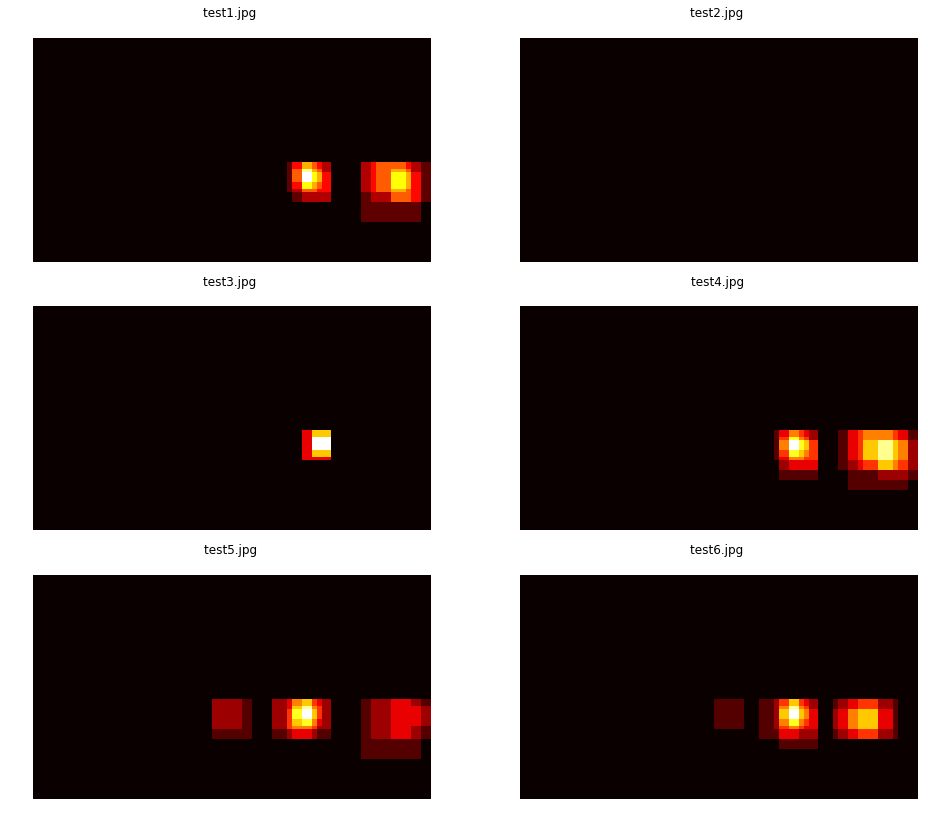

In [55]:
# Testing heatmap images with detected boxes
fig, axes = plt.subplots(3, 2, figsize=(16,14))
#fig.subplots_adjust(hspace = .004, wspace=.002)
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ind = i+1
    test_img = mpimg.imread('./test_images/test{ind}.jpg'.format(ind = ind))
    heatmap_img = np.zeros_like(test_img[:,:,0])
    # get detected boxes for the image:
    #boxes = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
    #              orient, pix_per_cell, cell_per_block, None, None)
    boxes = get_multi_boxes(test_img, colorspace,orient,pix_per_cell, cell_per_block,hog_channel)
    heatmap_img = add_heat(heatmap_img, boxes)
    
    window_img = draw_boxes(test_img, boxes)         
    ax.set_title('test{ind}.jpg \n'.format(ind = ind))
    ax.imshow(heatmap_img, cmap='hot')
    
plt.show()
#fig.savefig('output_images/test_images_with_multiboxes_heatmap_withcolorandspace.png')

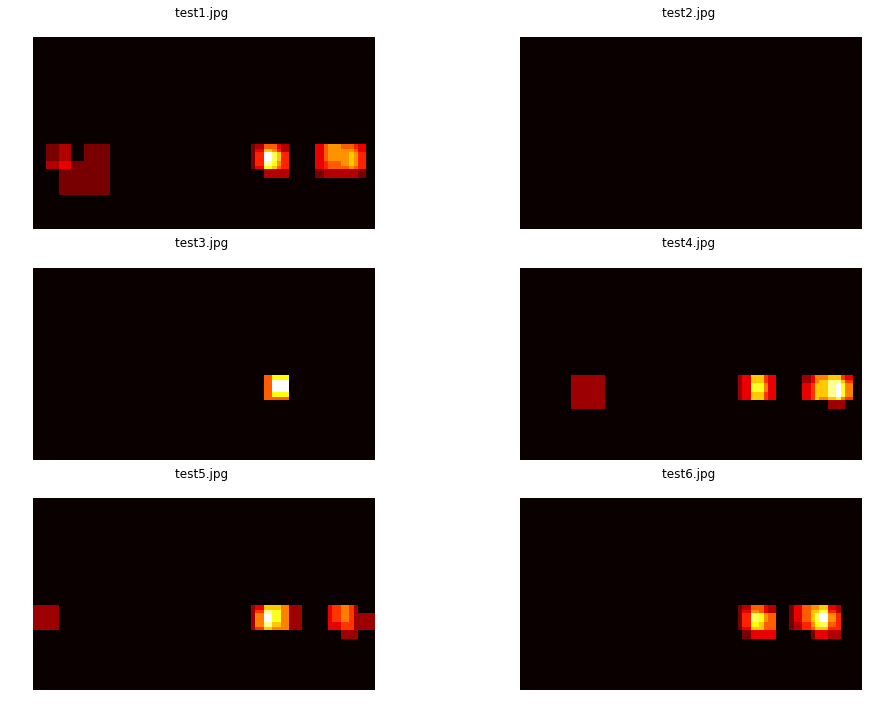

In [77]:
# Testing heatmap treshold images with detected boxes
fig, axes = plt.subplots(3, 2, figsize=(16,12))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ind = i+1
    test_img = mpimg.imread('./test_images/test{ind}.jpg'.format(ind = ind))
    heatmap_img = np.zeros_like(test_img[:,:,0])
    # get detected boxes for the image:
    #boxes = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
    #              orient, pix_per_cell, cell_per_block, None, None)
    boxes = get_multi_boxes(test_img, colorspace,orient,pix_per_cell, cell_per_block,hog_channel)
    heatmap_img = add_heat(heatmap_img, boxes)
    heatmap_img = apply_threshold(heatmap_img, 1)
    window_img = draw_boxes(test_img, boxes)         
    ax.set_title('test{ind}.jpg \n'.format(ind = ind))
    ax.imshow(heatmap_img, cmap='hot')
    
plt.show()
fig.savefig('output_images/test_images_with_multiboxes_heatmap_threshold.png')


### Labelling heatmap

Now labels is a 2-tuple, where the first item is an array the size of the heatmap input image and the second element is the number of labels (cars) found.


Num. boxes:  15
2 cars found


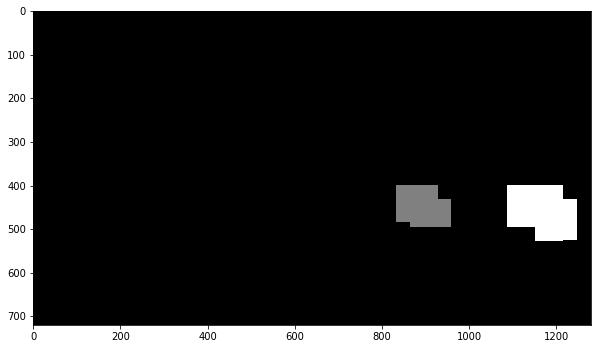

In [56]:
test_img = mpimg.imread('./test_images/test1.jpg')

boxes = get_multi_boxes(test_img,colorspace,orient,pix_per_cell, cell_per_block,hog_channel)
test_img_rects = draw_boxes(test_img, boxes,  thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Num. boxes: ', len(boxes))

heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, boxes)
heatmap_img = apply_threshold(heatmap_img, 2)

labels = label(heatmap_img)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
#fig.savefig('output_images/test_images_with_multiboxes_heatmap_label.png')

Num. boxes:  15


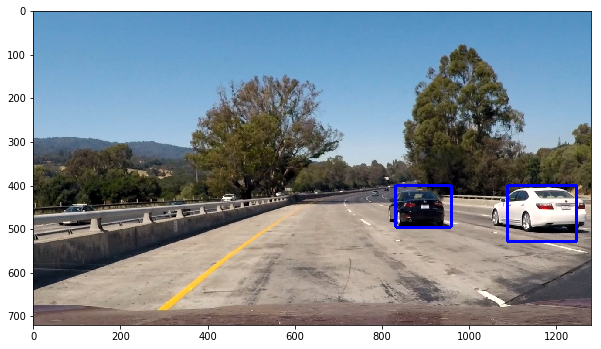

In [57]:
# Finally draw labeled boxes:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return (img)

# Read in the last image above
test_img = mpimg.imread('./test_images/test1.jpg')

boxes = get_multi_boxes(test_img, colorspace,orient,pix_per_cell, cell_per_block,hog_channel)
test_img_rects = draw_boxes(test_img, boxes,  thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Num. boxes: ', len(boxes))

heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, boxes)
heatmap_img = apply_threshold(heatmap_img, 2)

labels = label(heatmap_img)

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.imshow(draw_img)
fig.savefig('output_images/test1_withboxes_withcolornadspace_mix_labeled_boxes.png')

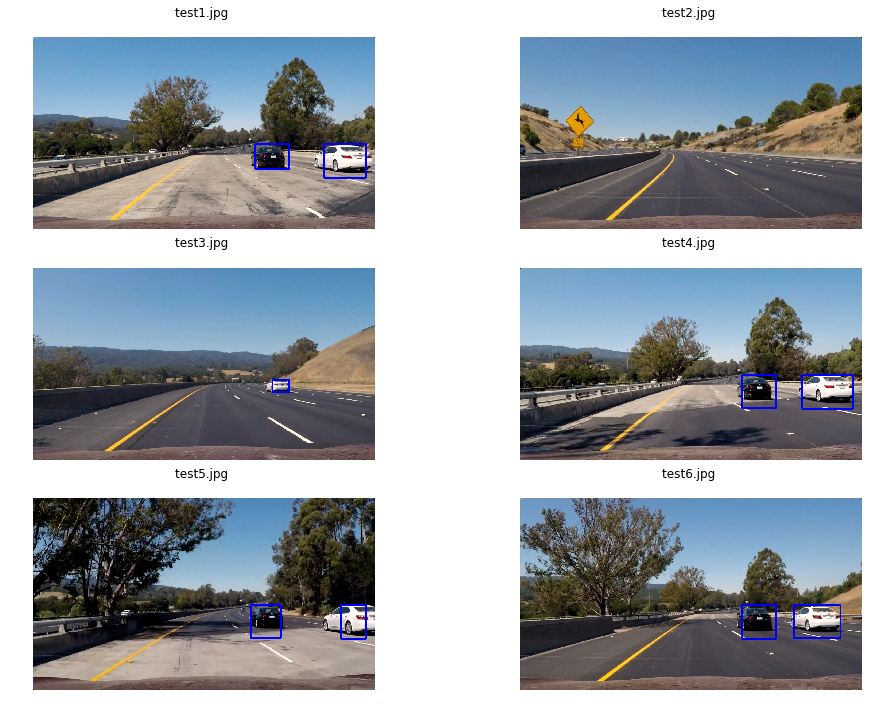

In [59]:
## Test images with multi boxes:
fig, axes = plt.subplots(3, 2, figsize=(16,12))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ind = i+1
    test_img = mpimg.imread('./test_images/test{ind}.jpg'.format(ind = ind))
    # get detected boxes for the image:
    #boxes = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
    #              orient, pix_per_cell, cell_per_block, None, None)
    boxes = get_multi_boxes(test_img,colorspace,orient,pix_per_cell, cell_per_block,hog_channel)
    
    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    heatmap_img = apply_threshold(heatmap_img, 2)

    labels = label(heatmap_img)

    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    ax.set_title('test{ind}.jpg \n'.format(ind = ind))
    ax.imshow(draw_img)
    
plt.show()
fig.savefig('output_images/test_images_withmultiboxes_withcolornadspace_labeled_boxes.png')

## PART 3: FINALE PIELINE

In [60]:
# define the global pipeline function to process one image:
def pipeline_image(img):
    
    #Fixing the parameters accordingly to the model already trained
    #------------------------------------------------------
    colorspace = 'YUV'#  RGB, HSV, LUV, HLS, YUV, YCrCb, 'YUV' 
    orient =    11 # 9 #
    pix_per_cell = 16 # 8 # 
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2
    spatial_size=(16, 16)
    hist_bins=16
    #------------------------------------------------------
    
    # get multi boxes with cars detected:
    boxes = get_multi_boxes(img,colorspace,orient,pix_per_cell, cell_per_block,hog_channel)
    
    # get heatmap from boxes lists
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    heatmap_img = apply_threshold(heatmap_img, 2)
    
    #apply labels function
    labels = label(heatmap_img)

    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return(draw_img)
    
    

In [ ]:
## testing the pipelin on test images...

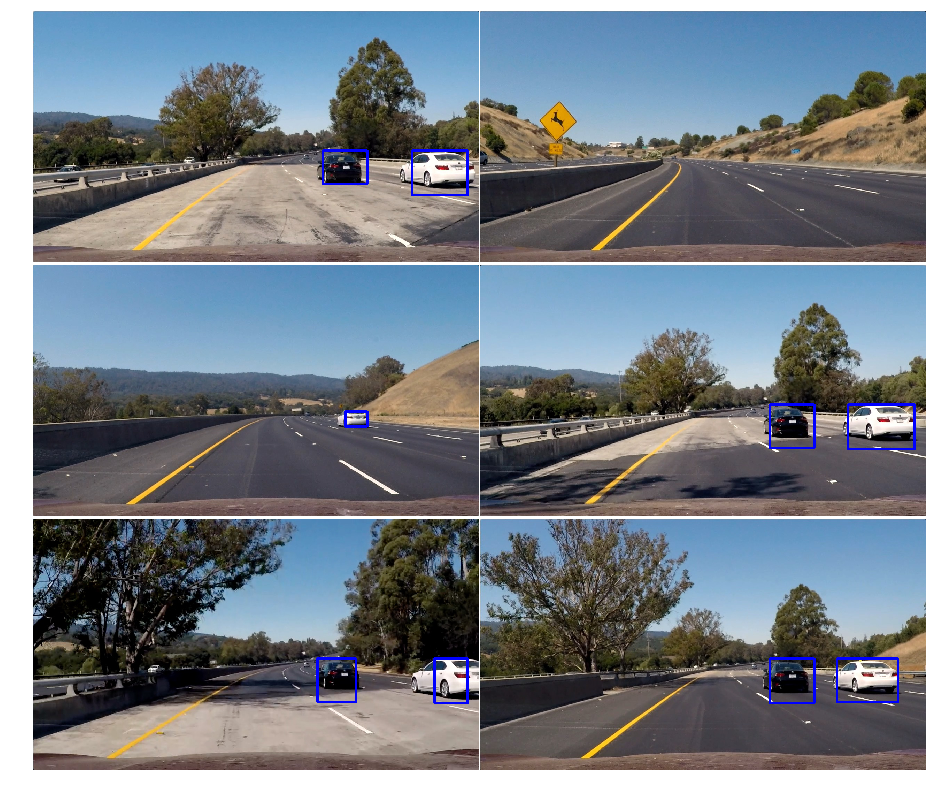

In [61]:
fig, axes = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ind = i+1
    img = mpimg.imread('./test_images/test{ind}.jpg'.format(ind = ind))
    ax.imshow(pipeline_image(img))
    ax.axis('off')
    
plt.show()
fig.savefig('output_images/test_images_after_pipeline_colorspace.png')

In [68]:
# define the global pipeline function to process one image:images from a video with historical data
class VehicleDetection():
    def __init__(self):
        # It stores historical data from vehicles found:
        self.vehicle_detected_boxes= [] 
        self.num_boxes_tokeep = 10
    
    def add_new_boxes(self, new_boxes_list):
        self.vehicle_detected_boxes.append(new_boxes_list)
        if len(self.vehicle_detected_boxes) > self.num_boxes_tokeep:
            # remove oldest boxes to just keep the same amount of boxes
            self.vehicle_detected_boxes = self.vehicle_detected_boxes[len(self.vehicle_detected_boxes)-self.num_boxes_tokeep:]


def pipeline_video(img, vd):
    
    #Fixing the parameters accordingly to the model already trained
    #------------------------------------------------------
    colorspace = 'YUV'#  RGB, HSV, LUV, HLS, YUV, YCrCb, 'YUV' 
    orient =    11 # 9 #
    pix_per_cell = 16 # 8 # 
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2
    spatial_size=(16, 16)
    hist_bins=16
    #------------------------------------------------------    
    
    # get multi boxes with cars detected:
    boxes = get_multi_boxes(img,colorspace,orient,pix_per_cell, cell_per_block,hog_channel)

    # add new cars detected
    if len(boxes) > 0:
        vd.add_new_boxes(boxes)
 
    # get heatmap from historical boxes lists
    heatmap_img = np.zeros_like(img[:,:,0])
    #heatmap_img = add_heat(heatmap_img, boxes)
    for rect_set in vd.vehicle_detected_boxes:
        heatmap_img = add_heat(heatmap_img, rect_set)
    threshold = 1 + len(vd.vehicle_detected_boxes)//2  
    #print('threshold: ', threshold)
    #heatmap_img = apply_threshold(heatmap_img, 2)

    heatmap_img = apply_threshold(heatmap_img, threshold)

    
    #apply labels function
    labels = label(heatmap_img)

    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return(draw_img)

In [64]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [87]:
# The pipeline without having into account recent boxes detected
def process_image(image):
    result = pipeline_image(image)
    return(result)

In [65]:
# The pipeline having into account recent boxes detected
def process_image(image):
    result = pipeline_video(image, vd)
    return(result)

### Applying pipeline to video

In [66]:
output = 'project_video_output_test.mp4'
clip1 = VideoFileClip("test_video.mp4")
vd = VehicleDetection()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output_test.mp4
[MoviePy] Writing video project_video_output_test.mp4


 97%|█████████▋| 38/39 [00:19<00:00,  1.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_test.mp4 

CPU times: user 25.2 s, sys: 120 ms, total: 25.3 s
Wall time: 20.8 s


In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [69]:
# Project video
output_project = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")

# Initialize class VehicleDetection
vd = VehicleDetection()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_project, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [10:41<00:00,  1.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 13min 42s, sys: 3.04 s, total: 13min 45s
Wall time: 10min 42s


In [70]:
output_project = 'project_video_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_project))